# 第45章: Diffusersライブラリ実践

## 📋 この章で学ぶこと

この章を終えると、以下ができるようになります：

- [ ] Diffusersライブラリの基本的な使い方を理解できる
- [ ] Text-to-Image生成を実行できる
- [ ] Image-to-Image変換を実行できる
- [ ] パイプラインのカスタマイズ方法を理解できる

## 🎯 前提知識

この章を学ぶには以下の知識が必要です：

- ✅ Notebook 37-44（拡散モデルの理論と実装）

⏱️ **推定学習時間**: 90-120分  
📊 **難易度**: ★★★☆☆（中級）  
🎓 **カテゴリ**: 実践

---

## 🌟 はじめに

**Diffusers**はHugging Faceが開発した拡散モデルのライブラリです。

### 📊 Diffusersの特徴

| 特徴 | 説明 |
|------|------|
| **事前訓練モデル** | Stable Diffusion, DALL-E等を簡単に利用 |
| **パイプライン** | 複雑な処理を1行で実行 |
| **モジュール性** | 個々のコンポーネントを自由に組み合わせ |
| **最適化** | メモリ効率、高速化機能 |

### 💡 主要コンポーネント

1. **Pipeline**: エンドツーエンドの生成パイプライン
2. **Scheduler**: ノイズスケジュール管理（DDPM, DDIM, Euler等）
3. **Model**: U-Net, VAE, テキストエンコーダ

### ⚠️ 注意

この章では実際のモデルを使用しますが、GPUメモリの制約がある場合は一部のセルがスキップされることがあります。

In [1]:
# ============================================================
# 環境設定
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from PIL import Image
import io

import torch

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# 日本語フォント設定
import matplotlib.font_manager as fm

def setup_japanese_font():
    japanese_fonts = [
        'Hiragino Sans', 'Hiragino Maru Gothic Pro', 'AppleGothic',
        'Yu Gothic', 'MS Gothic', 'Noto Sans CJK JP', 'IPAexGothic',
    ]
    available_fonts = set(f.name for f in fm.fontManager.ttflist)
    for font in japanese_fonts:
        if font in available_fonts:
            plt.rcParams['font.family'] = font
            plt.rcParams['axes.unicode_minus'] = False
            return font
    return None

font_used = setup_japanese_font()
if font_used:
    print(f"日本語フォント: {font_used}")

# デバイス設定
if torch.cuda.is_available():
    device = "cuda"
    print(f"CUDA GPU: {torch.cuda.get_device_name(0)}")
    print(f"VRAM: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
elif torch.backends.mps.is_available():
    device = "mps"
    print("Using MPS (Apple Silicon)")
else:
    device = "cpu"
    print("Using CPU (slow)")

torch.manual_seed(42)
np.random.seed(42)

print("\n✅ 環境設定完了")

日本語フォント: Hiragino Sans
Using MPS (Apple Silicon)

✅ 環境設定完了


In [2]:
# ============================================================
# Diffusersライブラリのインポート
# ============================================================

try:
    from diffusers import (
        DiffusionPipeline,
        StableDiffusionPipeline,
        StableDiffusionImg2ImgPipeline,
        DDPMPipeline,
        DDPMScheduler,
        DDIMScheduler,
        EulerDiscreteScheduler,
        AutoencoderKL,
        UNet2DConditionModel,
    )
    from transformers import CLIPTextModel, CLIPTokenizer
    DIFFUSERS_AVAILABLE = True
    print("✅ Diffusersライブラリをインポートしました")
except ImportError:
    DIFFUSERS_AVAILABLE = False
    print("❌ Diffusersがインストールされていません")
    print("   インストール: pip install diffusers transformers accelerate")

✅ Diffusersライブラリをインポートしました


---

## 1. Diffusersの基本構造

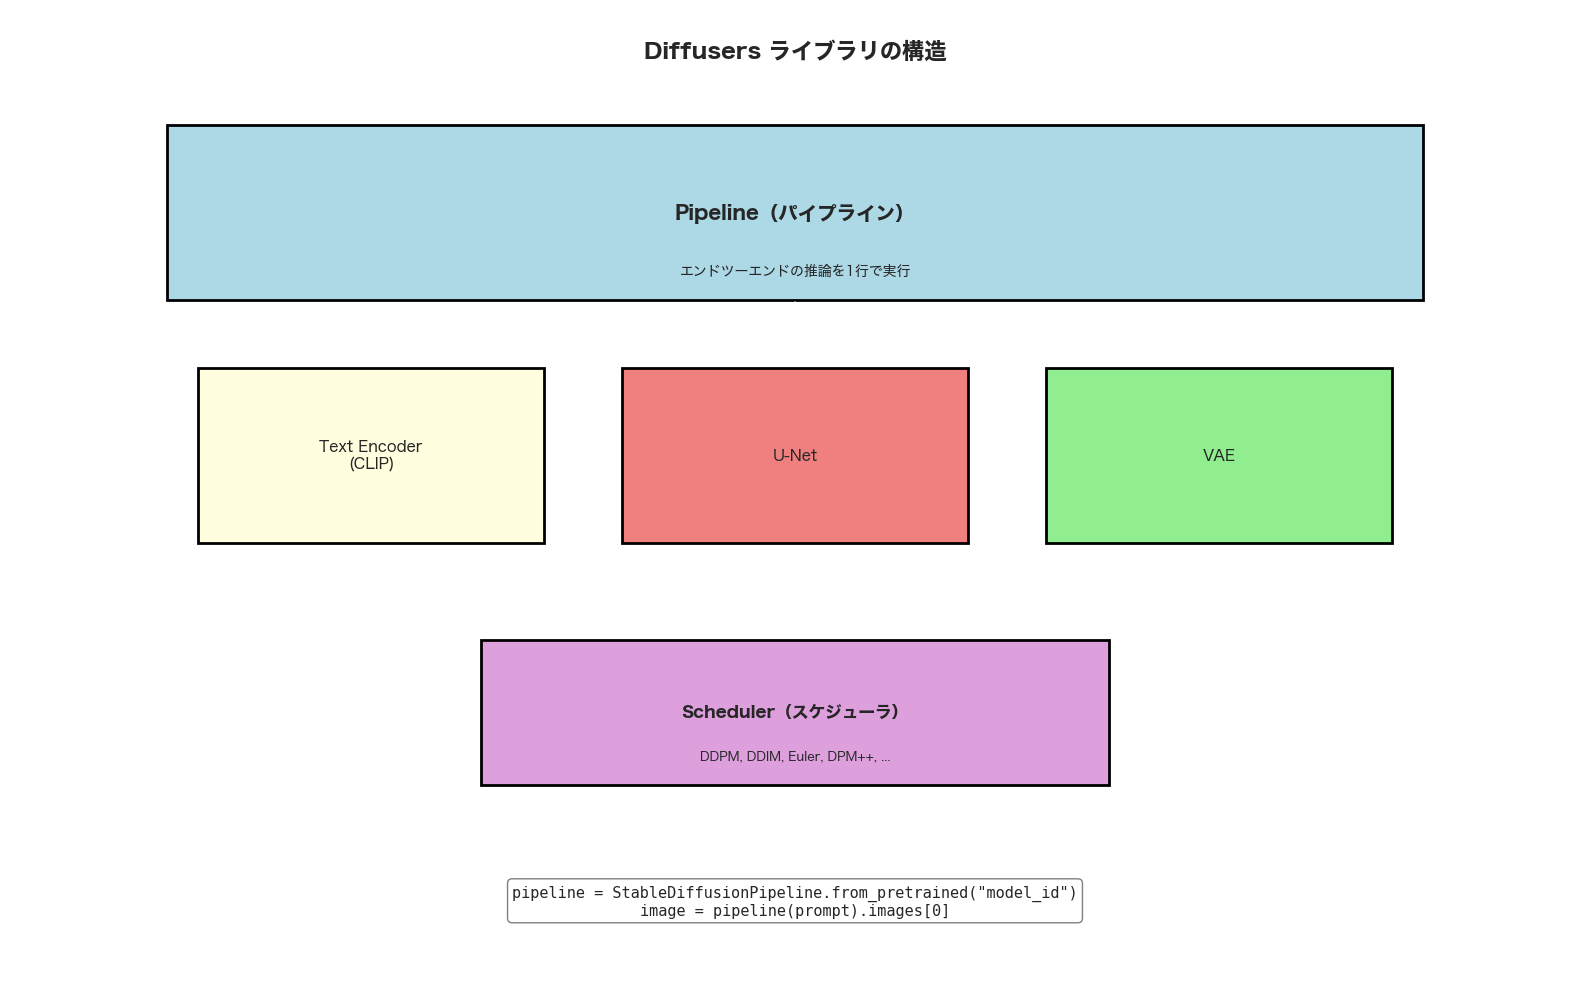

In [3]:
# ============================================================
# Diffusersの構造図
# ============================================================

fig, ax = plt.subplots(figsize=(16, 10))

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

ax.text(0.5, 0.95, 'Diffusers ライブラリの構造', fontsize=16, fontweight='bold', ha='center')

# Pipeline
ax.add_patch(plt.Rectangle((0.1, 0.7), 0.8, 0.18, 
                           facecolor='lightblue', edgecolor='black', lw=2))
ax.text(0.5, 0.79, 'Pipeline（パイプライン）', ha='center', va='center', 
        fontsize=14, fontweight='bold')
ax.text(0.5, 0.73, 'エンドツーエンドの推論を1行で実行', ha='center', va='center', fontsize=10)

# 内部コンポーネント
components = [
    (0.12, 0.45, 0.22, 0.18, 'Text Encoder\n(CLIP)', 'lightyellow'),
    (0.39, 0.45, 0.22, 0.18, 'U-Net', 'lightcoral'),
    (0.66, 0.45, 0.22, 0.18, 'VAE', 'lightgreen'),
]

for x, y, w, h, label, color in components:
    ax.add_patch(plt.Rectangle((x, y), w, h, facecolor=color, edgecolor='black', lw=2))
    ax.text(x + w/2, y + h/2, label, ha='center', va='center', fontsize=11)

# Scheduler
ax.add_patch(plt.Rectangle((0.3, 0.2), 0.4, 0.15, 
                           facecolor='plum', edgecolor='black', lw=2))
ax.text(0.5, 0.275, 'Scheduler（スケジューラ）', ha='center', va='center', 
        fontsize=12, fontweight='bold')
ax.text(0.5, 0.23, 'DDPM, DDIM, Euler, DPM++, ...', ha='center', va='center', fontsize=9)

# 矢印
ax.annotate('', xy=(0.5, 0.63), xytext=(0.5, 0.70),
            arrowprops=dict(arrowstyle='->', lw=2))
ax.annotate('', xy=(0.5, 0.35), xytext=(0.5, 0.45),
            arrowprops=dict(arrowstyle='<->', lw=2))

# 説明
ax.text(0.5, 0.08, 
        'pipeline = StableDiffusionPipeline.from_pretrained("model_id")\n'
        'image = pipeline(prompt).images[0]',
        ha='center', va='center', fontsize=11, family='monospace',
        bbox=dict(boxstyle='round', facecolor='white', edgecolor='gray'))

ax.axis('off')
plt.tight_layout()
plt.show()

---

## 2. シンプルなDDPMパイプライン

まず、MNISTのような簡単なモデルから始めます。

軽量DDPMモデルをロード中...


Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

An error occurred while trying to fetch /Users/ikmx/.cache/huggingface/hub/models--google--ddpm-cifar10-32/snapshots/267b167dc01f0e4e61923ea244e8b988f84deb80: Error no file named diffusion_pytorch_model.safetensors found in directory /Users/ikmx/.cache/huggingface/hub/models--google--ddpm-cifar10-32/snapshots/267b167dc01f0e4e61923ea244e8b988f84deb80.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.



サンプル生成中...


  0%|          | 0/50 [00:00<?, ?it/s]

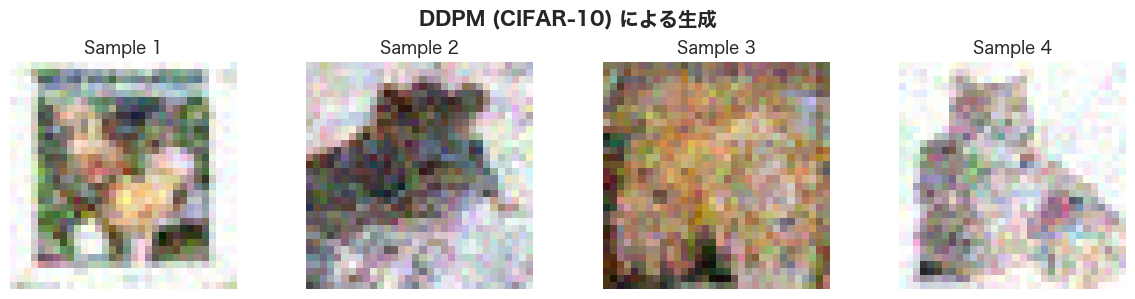

In [4]:
# ============================================================
# DDPMパイプラインの使用例
# ============================================================

if DIFFUSERS_AVAILABLE:
    # 軽量なDDPMモデルをロード（MNIST/CIFAR用）
    # 注意: これは教育用の小さなモデルです
    
    try:
        # Hugging Face Hubから軽量モデルを試す
        print("軽量DDPMモデルをロード中...")
        ddpm_pipeline = DDPMPipeline.from_pretrained(
            "google/ddpm-cifar10-32",
            torch_dtype=torch.float32,
        ).to(device)
        
        print("\nサンプル生成中...")
        with torch.no_grad():
            # 4枚の画像を生成
            images = ddpm_pipeline(
                batch_size=4,
                num_inference_steps=50,  # 高速化のため短縮
            ).images
        
        # 表示
        fig, axes = plt.subplots(1, 4, figsize=(12, 3))
        for i, (ax, img) in enumerate(zip(axes, images)):
            ax.imshow(img)
            ax.axis('off')
            ax.set_title(f'Sample {i+1}')
        plt.suptitle('DDPM (CIFAR-10) による生成', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
        
        # メモリ解放
        del ddpm_pipeline
        torch.cuda.empty_cache() if torch.cuda.is_available() else None
        
    except Exception as e:
        print(f"モデルのロードに失敗: {e}")
        print("代わりにDiffusersの構造を説明します。")
else:
    print("Diffusersがインストールされていないため、スキップします。")

---

## 3. スケジューラの比較

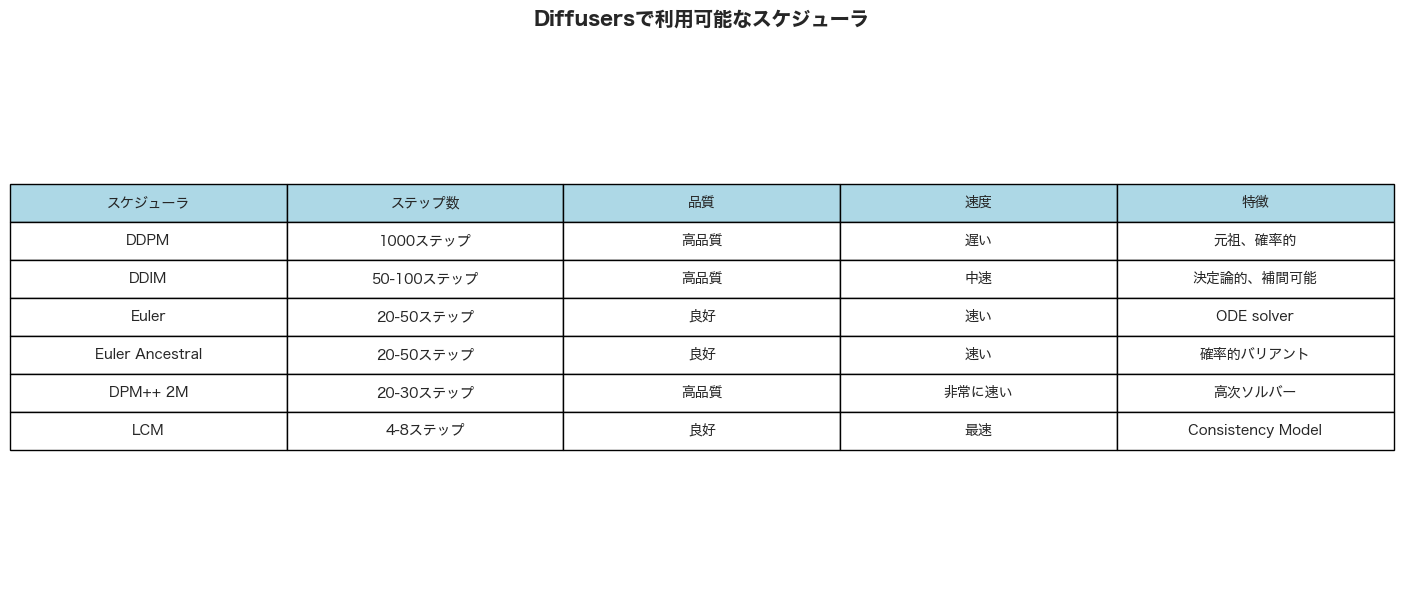

In [5]:
# ============================================================
# 各スケジューラの特性
# ============================================================

schedulers_info = [
    ('DDPM', '1000ステップ', '高品質', '遅い', '元祖、確率的'),
    ('DDIM', '50-100ステップ', '高品質', '中速', '決定論的、補間可能'),
    ('Euler', '20-50ステップ', '良好', '速い', 'ODE solver'),
    ('Euler Ancestral', '20-50ステップ', '良好', '速い', '確率的バリアント'),
    ('DPM++ 2M', '20-30ステップ', '高品質', '非常に速い', '高次ソルバー'),
    ('LCM', '4-8ステップ', '良好', '最速', 'Consistency Model'),
]

fig, ax = plt.subplots(figsize=(14, 6))

table_data = [['スケジューラ', 'ステップ数', '品質', '速度', '特徴']] + schedulers_info

table = ax.table(
    cellText=table_data[1:],
    colLabels=table_data[0],
    loc='center',
    cellLoc='center',
)

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 2)

# ヘッダーの色
for i in range(5):
    table[(0, i)].set_facecolor('lightblue')

ax.axis('off')
ax.set_title('Diffusersで利用可能なスケジューラ', fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

In [6]:
# ============================================================
# スケジューラの切り替え方法
# ============================================================

if DIFFUSERS_AVAILABLE:
    print("スケジューラの切り替え例:")
    print()
    print('# パイプラインをロード')
    print('pipe = StableDiffusionPipeline.from_pretrained("model_id")')
    print()
    print('# スケジューラを変更')
    print('from diffusers import EulerDiscreteScheduler')
    print('pipe.scheduler = EulerDiscreteScheduler.from_config(pipe.scheduler.config)')
    print()
    print('# または DPM++ 2M（高速・高品質）')
    print('from diffusers import DPMSolverMultistepScheduler')
    print('pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)')

スケジューラの切り替え例:

# パイプラインをロード
pipe = StableDiffusionPipeline.from_pretrained("model_id")

# スケジューラを変更
from diffusers import EulerDiscreteScheduler
pipe.scheduler = EulerDiscreteScheduler.from_config(pipe.scheduler.config)

# または DPM++ 2M（高速・高品質）
from diffusers import DPMSolverMultistepScheduler
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)


---

## 4. Text-to-Image生成

Stable Diffusionを使った実践的なテキストからの画像生成。

### ⚠️ メモリ要件

Stable Diffusionには最低8GB以上のVRAM（またはMPS）が必要です。

In [7]:
# ============================================================
# Stable Diffusion パイプライン（コード例）
# ============================================================

print("=" * 60)
print("Stable Diffusion Text-to-Image 使用例")
print("=" * 60)
print()

code_example = '''
from diffusers import StableDiffusionPipeline
import torch

# モデルをロード
model_id = "runwayml/stable-diffusion-v1-5"
pipe = StableDiffusionPipeline.from_pretrained(
    model_id,
    torch_dtype=torch.float16,  # メモリ節約
)
pipe = pipe.to("cuda")  # または "mps"

# メモリ最適化（オプション）
pipe.enable_attention_slicing()  # メモリ使用量削減
# pipe.enable_xformers_memory_efficient_attention()  # xformersがある場合

# 画像を生成
prompt = "a photo of an astronaut riding a horse on mars"
negative_prompt = "blurry, low quality, watermark"

image = pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=30,
    guidance_scale=7.5,
    width=512,
    height=512,
).images[0]

# 保存
image.save("astronaut_horse.png")
'''

print(code_example)

Stable Diffusion Text-to-Image 使用例


from diffusers import StableDiffusionPipeline
import torch

# モデルをロード
model_id = "runwayml/stable-diffusion-v1-5"
pipe = StableDiffusionPipeline.from_pretrained(
    model_id,
    torch_dtype=torch.float16,  # メモリ節約
)
pipe = pipe.to("cuda")  # または "mps"

# メモリ最適化（オプション）
pipe.enable_attention_slicing()  # メモリ使用量削減
# pipe.enable_xformers_memory_efficient_attention()  # xformersがある場合

# 画像を生成
prompt = "a photo of an astronaut riding a horse on mars"
negative_prompt = "blurry, low quality, watermark"

image = pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=30,
    guidance_scale=7.5,
    width=512,
    height=512,
).images[0]

# 保存
image.save("astronaut_horse.png")



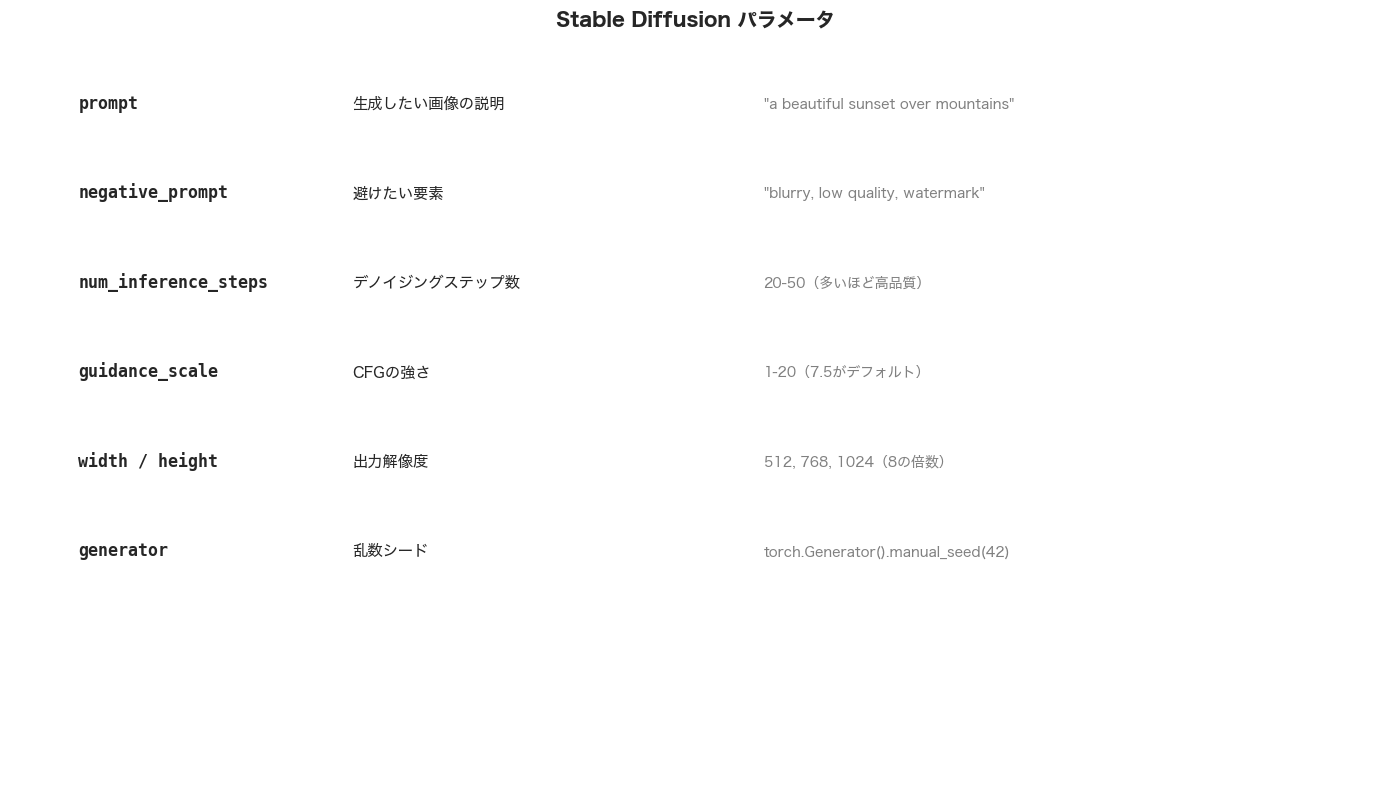

In [8]:
# ============================================================
# パラメータの説明
# ============================================================

fig, ax = plt.subplots(figsize=(14, 8))

params = [
    ('prompt', '生成したい画像の説明', '"a beautiful sunset over mountains"'),
    ('negative_prompt', '避けたい要素', '"blurry, low quality, watermark"'),
    ('num_inference_steps', 'デノイジングステップ数', '20-50（多いほど高品質）'),
    ('guidance_scale', 'CFGの強さ', '1-20（7.5がデフォルト）'),
    ('width / height', '出力解像度', '512, 768, 1024（8の倍数）'),
    ('generator', '乱数シード', 'torch.Generator().manual_seed(42)'),
]

y_pos = 0.9
for param, desc, example in params:
    ax.text(0.05, y_pos, param, fontsize=12, fontweight='bold', family='monospace')
    ax.text(0.25, y_pos, desc, fontsize=11)
    ax.text(0.55, y_pos, example, fontsize=10, style='italic', color='gray')
    y_pos -= 0.12

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.axis('off')
ax.set_title('Stable Diffusion パラメータ', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

---

## 5. Image-to-Image変換

In [9]:
# ============================================================
# Image-to-Image 使用例
# ============================================================

print("=" * 60)
print("Stable Diffusion Image-to-Image 使用例")
print("=" * 60)
print()

code_example = '''
from diffusers import StableDiffusionImg2ImgPipeline
from PIL import Image
import torch

# パイプラインをロード
pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    torch_dtype=torch.float16,
).to("cuda")

# 入力画像を読み込み
init_image = Image.open("input.png").convert("RGB")
init_image = init_image.resize((512, 512))

# 画像を変換
prompt = "a fantasy landscape with dragons, digital art"

image = pipe(
    prompt=prompt,
    image=init_image,
    strength=0.75,  # 元画像をどれだけ変更するか (0.0-1.0)
    guidance_scale=7.5,
    num_inference_steps=30,
).images[0]

image.save("output.png")
'''

print(code_example)

Stable Diffusion Image-to-Image 使用例


from diffusers import StableDiffusionImg2ImgPipeline
from PIL import Image
import torch

# パイプラインをロード
pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    torch_dtype=torch.float16,
).to("cuda")

# 入力画像を読み込み
init_image = Image.open("input.png").convert("RGB")
init_image = init_image.resize((512, 512))

# 画像を変換
prompt = "a fantasy landscape with dragons, digital art"

image = pipe(
    prompt=prompt,
    image=init_image,
    strength=0.75,  # 元画像をどれだけ変更するか (0.0-1.0)
    guidance_scale=7.5,
    num_inference_steps=30,
).images[0]

image.save("output.png")



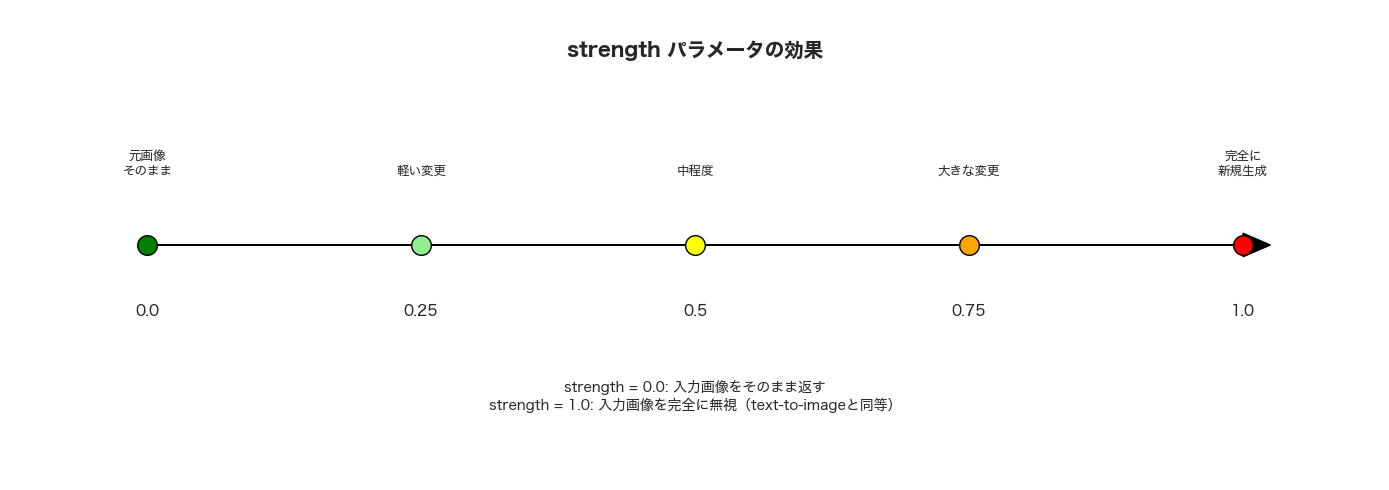

In [10]:
# ============================================================
# strength パラメータの効果
# ============================================================

fig, ax = plt.subplots(figsize=(14, 5))

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

ax.text(0.5, 0.9, 'strength パラメータの効果', fontsize=14, fontweight='bold', ha='center')

# スケール
ax.arrow(0.1, 0.5, 0.8, 0, head_width=0.05, head_length=0.02, fc='black', ec='black')

# マーカー
strengths = [0.0, 0.25, 0.5, 0.75, 1.0]
labels = ['元画像\nそのまま', '軽い変更', '中程度', '大きな変更', '完全に\n新規生成']
colors = ['green', 'lightgreen', 'yellow', 'orange', 'red']

for s, label, color in zip(strengths, labels, colors):
    x = 0.1 + s * 0.8
    ax.scatter(x, 0.5, s=200, c=color, edgecolor='black', zorder=5)
    ax.text(x, 0.35, f'{s}', ha='center', fontsize=11)
    ax.text(x, 0.65, label, ha='center', fontsize=9)

ax.text(0.5, 0.15, 
        'strength = 0.0: 入力画像をそのまま返す\n'
        'strength = 1.0: 入力画像を完全に無視（text-to-imageと同等）',
        ha='center', fontsize=10, style='italic')

ax.axis('off')
plt.tight_layout()
plt.show()

---

## 6. メモリ最適化テクニック

In [11]:
# ============================================================
# メモリ最適化オプション
# ============================================================

print("=" * 60)
print("メモリ最適化テクニック")
print("=" * 60)
print()

techniques = [
    ("torch.float16", "VRAMを約半分に削減", "ほぼなし", "最初に試すべき"),
    ("enable_attention_slicing()", "Attentionを分割計算", "やや遅くなる", "低VRAM環境で有効"),
    ("enable_vae_slicing()", "VAEを分割処理", "やや遅くなる", "大きな画像生成時"),
    ("enable_model_cpu_offload()", "モデルをCPUに退避", "遅くなる", "6GB以下のVRAM"),
    ("enable_sequential_cpu_offload()", "レイヤー単位で退避", "かなり遅い", "4GB以下のVRAM"),
    ("xformers", "最適化されたAttention", "なし", "利用可能なら必須"),
]

for technique, effect, tradeoff, when in techniques:
    print(f"📌 {technique}")
    print(f"   効果: {effect}")
    print(f"   トレードオフ: {tradeoff}")
    print(f"   使用場面: {when}")
    print()

メモリ最適化テクニック

📌 torch.float16
   効果: VRAMを約半分に削減
   トレードオフ: ほぼなし
   使用場面: 最初に試すべき

📌 enable_attention_slicing()
   効果: Attentionを分割計算
   トレードオフ: やや遅くなる
   使用場面: 低VRAM環境で有効

📌 enable_vae_slicing()
   効果: VAEを分割処理
   トレードオフ: やや遅くなる
   使用場面: 大きな画像生成時

📌 enable_model_cpu_offload()
   効果: モデルをCPUに退避
   トレードオフ: 遅くなる
   使用場面: 6GB以下のVRAM

📌 enable_sequential_cpu_offload()
   効果: レイヤー単位で退避
   トレードオフ: かなり遅い
   使用場面: 4GB以下のVRAM

📌 xformers
   効果: 最適化されたAttention
   トレードオフ: なし
   使用場面: 利用可能なら必須



In [12]:
# ============================================================
# 最適化コード例
# ============================================================

print("最適化コード例:")
print()

code = '''
# 1. float16を使用
pipe = StableDiffusionPipeline.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
).to("cuda")

# 2. Attention slicing
pipe.enable_attention_slicing()

# 3. xformers（インストールされている場合）
try:
    pipe.enable_xformers_memory_efficient_attention()
except:
    pass

# 4. 低VRAMの場合
pipe.enable_model_cpu_offload()

# 5. 非常に低VRAMの場合（遅くなる）
pipe.enable_sequential_cpu_offload()
'''

print(code)

最適化コード例:


# 1. float16を使用
pipe = StableDiffusionPipeline.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
).to("cuda")

# 2. Attention slicing
pipe.enable_attention_slicing()

# 3. xformers（インストールされている場合）
try:
    pipe.enable_xformers_memory_efficient_attention()
except:
    pass

# 4. 低VRAMの場合
pipe.enable_model_cpu_offload()

# 5. 非常に低VRAMの場合（遅くなる）
pipe.enable_sequential_cpu_offload()



---

## 7. 高度な使用法

In [13]:
# ============================================================
# 高度な機能
# ============================================================

print("=" * 60)
print("Diffusersの高度な機能")
print("=" * 60)
print()

advanced_features = [
    ("ControlNet", "ポーズ、エッジ、深度などで制御", "StableDiffusionControlNetPipeline"),
    ("Inpainting", "画像の一部を修正", "StableDiffusionInpaintPipeline"),
    ("Upscaling", "画像の高解像度化", "StableDiffusionUpscalePipeline"),
    ("LoRA", "軽量ファインチューニング", "pipe.load_lora_weights()"),
    ("Textual Inversion", "カスタムコンセプト学習", "pipe.load_textual_inversion()"),
    ("SDXL", "高解像度モデル", "StableDiffusionXLPipeline"),
]

for feature, desc, usage in advanced_features:
    print(f"🔧 {feature}")
    print(f"   説明: {desc}")
    print(f"   使用: {usage}")
    print()

Diffusersの高度な機能

🔧 ControlNet
   説明: ポーズ、エッジ、深度などで制御
   使用: StableDiffusionControlNetPipeline

🔧 Inpainting
   説明: 画像の一部を修正
   使用: StableDiffusionInpaintPipeline

🔧 Upscaling
   説明: 画像の高解像度化
   使用: StableDiffusionUpscalePipeline

🔧 LoRA
   説明: 軽量ファインチューニング
   使用: pipe.load_lora_weights()

🔧 Textual Inversion
   説明: カスタムコンセプト学習
   使用: pipe.load_textual_inversion()

🔧 SDXL
   説明: 高解像度モデル
   使用: StableDiffusionXLPipeline



In [14]:
# ============================================================
# LoRAの使用例
# ============================================================

print("LoRAの使用例:")
print()

code = '''
from diffusers import StableDiffusionPipeline

pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    torch_dtype=torch.float16,
).to("cuda")

# LoRAをロード
pipe.load_lora_weights(
    "path/to/lora",  # ローカルパスまたはHugging Face Hub ID
    weight_name="lora_file.safetensors",
)

# LoRAの強さを調整
pipe.fuse_lora(lora_scale=0.8)  # 0.0-1.0

# 画像を生成
image = pipe("prompt").images[0]

# LoRAを解除
pipe.unfuse_lora()
'''

print(code)

LoRAの使用例:


from diffusers import StableDiffusionPipeline

pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    torch_dtype=torch.float16,
).to("cuda")

# LoRAをロード
pipe.load_lora_weights(
    "path/to/lora",  # ローカルパスまたはHugging Face Hub ID
    weight_name="lora_file.safetensors",
)

# LoRAの強さを調整
pipe.fuse_lora(lora_scale=0.8)  # 0.0-1.0

# 画像を生成
image = pipe("prompt").images[0]

# LoRAを解除
pipe.unfuse_lora()



---

## まとめ

### 🎯 このノートブックで学んだこと

**Diffusersの基本**
- ✓ パイプラインの構造
- ✓ モデルのロード方法
- ✓ 基本的な画像生成

**スケジューラ**
- ✓ 各スケジューラの特性
- ✓ スケジューラの切り替え方法
- ✓ 速度と品質のトレードオフ

**実践的なテクニック**
- ✓ Text-to-Image
- ✓ Image-to-Image
- ✓ メモリ最適化
- ✓ LoRAなどの高度な機能

### 📊 パイプラインの種類

| パイプライン | 用途 |
|-------------|------|
| `StableDiffusionPipeline` | テキストから画像生成 |
| `StableDiffusionImg2ImgPipeline` | 画像から画像変換 |
| `StableDiffusionInpaintPipeline` | 画像の部分修正 |
| `StableDiffusionControlNetPipeline` | 構造制御付き生成 |
| `StableDiffusionXLPipeline` | 高解像度生成 |

---

## 🎓 自己評価クイズ

### Q1: Diffusersでスケジューラを変更する方法は？

<details>
<summary>💡 答えを見る</summary>

**答え**:
```python
from diffusers import EulerDiscreteScheduler
pipe.scheduler = EulerDiscreteScheduler.from_config(pipe.scheduler.config)
```

`from_config`を使って既存の設定を引き継ぎつつ、新しいスケジューラを適用します。

</details>

---

### Q2: Image-to-Imageでstrength=0.5と1.0の違いは？

<details>
<summary>💡 答えを見る</summary>

**答え**:
- **strength=0.5**: 元画像の構造を半分程度保持しながら変換
- **strength=1.0**: 元画像を完全に無視（text-to-imageと同等）

strengthが低いほど元画像に忠実、高いほどプロンプトに忠実な画像が生成されます。

</details>

---

### Q3: VRAMが少ない場合の最適化方法は？

<details>
<summary>💡 答えを見る</summary>

**答え**:
1. `torch_dtype=torch.float16` を使用
2. `pipe.enable_attention_slicing()`
3. `pipe.enable_model_cpu_offload()`
4. xformersがあれば `pipe.enable_xformers_memory_efficient_attention()`

</details>

---

### ✅ 学習チェックリスト

- [ ] Diffusersパイプラインを使って画像を生成できる
- [ ] スケジューラを切り替えられる
- [ ] 各パラメータの効果を理解している
- [ ] メモリ最適化の方法を知っている

---

## 🎉 拡散モデルシリーズ完了！

おめでとうございます！Notebook 37-45で拡散モデルを体系的に学習しました。

### 📚 学習の軌跡

| Notebook | 内容 |
|----------|------|
| 37-38 | 拡散モデルの理論（基礎とELBO） |
| 39 | U-Netと位置エンコーディング |
| 40-41 | DDPMとDDIM実装 |
| 42 | Classifier-Free Guidance |
| 43 | 潜在拡散モデル（LDM） |
| 44 | テキスト条件付けとCLIP |
| 45 | Diffusersライブラリ実践 |

### 🚀 今後の発展

- **ControlNet**: より精密な制御
- **Video Diffusion**: 動画生成
- **3D Diffusion**: 3Dモデル生成
- **音声Diffusion**: 音楽・音声生成